# Telo Customer Logistic Regression With R
- Analysis focuses on the behavior of telecom customers who are more likely to leave the platform
- The analysis is done using R

In [4]:
# libraries loading
suppressMessages({
    library(tidyverse)
    library(MASS)
    library(car)
    library(e1071)
    library(caret)
    library(cowplot)
    library(caTools)
    library(pROC)
    library(ggcorrplot)
})


In [5]:
# load data
telco = read.csv("../../data/telco_customer.csv")

In [6]:
# get information from the dataset
glimpse(telco)

Rows: 7,043
Columns: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CFOCW…
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",…
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes…
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"…
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2…
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", …
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "…
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt…
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "…
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N…
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y…
$ TechSupport   

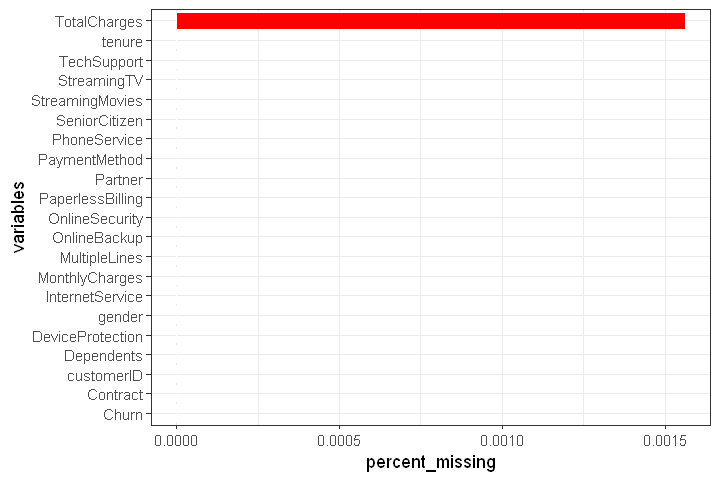

In [11]:
# check percentage empty in data
options(warn = -1) # suppress warnings globally
options(repr.plot.width = 6, repr.plot.height = 4)

missing_data <- telco %>% summarise_all(funs(sum(is.na(.))/n()))
missing_data <- gather(missing_data, key = "variables", value = "percent_missing")
ggplot(missing_data, aes(x = reorder(variables, percent_missing), y = percent_missing)) +
geom_bar(stat = "identity", fill = "red", aes(color = I('white')), size = 0.3)+
xlab('variables')+
coord_flip()+ 
theme_bw()

- Only 11 missing data in the `TotalCharges` field
- `Tenure`, `MonthlyCharges` and `TotalCharges` are continuous
- `SeniorCitizen` can be changes to categorical

In [13]:
telco <- telco[complete.cases(telco),]

telco$SeniorCitizen <- as.factor(ifelse(telco$SeniorCitizen == 1, "Yes", "No"))

In [14]:
theme1 <- theme_bw() +
    theme(axis.text.x = element_text(angle = 0, hjust = 1, vjust = 0.5), legend.poistion = "none")
theme2 <- theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.poistion = "none")

In [15]:
glimpse(telco)

Rows: 7,032
Columns: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CFOCW…
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",…
$ SeniorCitizen    <fct> No, No, No, No, No, No, No, No, No, No, No, No, No, N…
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes…
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"…
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2…
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", …
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "…
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt…
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "…
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N…
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y…
$ TechSupport   

## Data Visualization

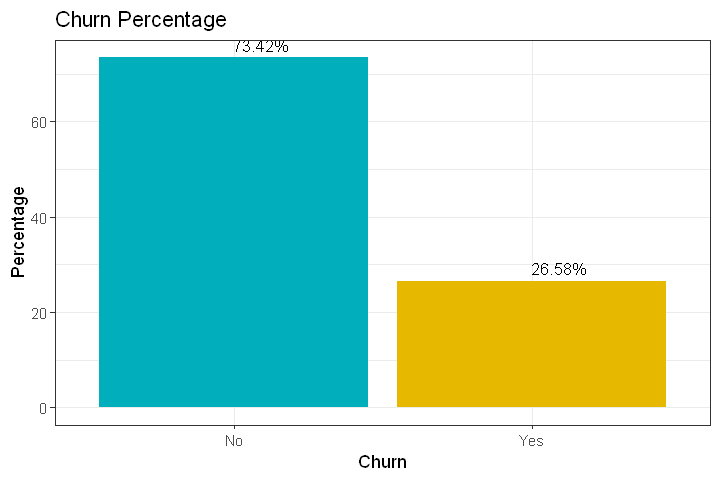

In [16]:
telco %>%
    group_by(Churn) %>%
    summarise(Count = n()) %>%
    mutate(percent = prop.table(Count)*100) %>%
    ggplot(aes(reorder(Churn, -percent), percent, fill = Churn)) +
    geom_col(fill = c("#00AFBB", "#E7B800")) +
    geom_text(aes(label = sprintf("%.2f%%", percent)), hjust = 0.01, vjust = -0.5, size = 3.5) +
    theme_bw() +
    xlab("Churn") +
    ylab("Percentage") +
    ggtitle("Churn Percentage")

- We have an equal case of male and female
- Percentage of churn is higher in `senior citizen`
- Customers with `partners` and `dependends` have lower churn rate then does who do not have

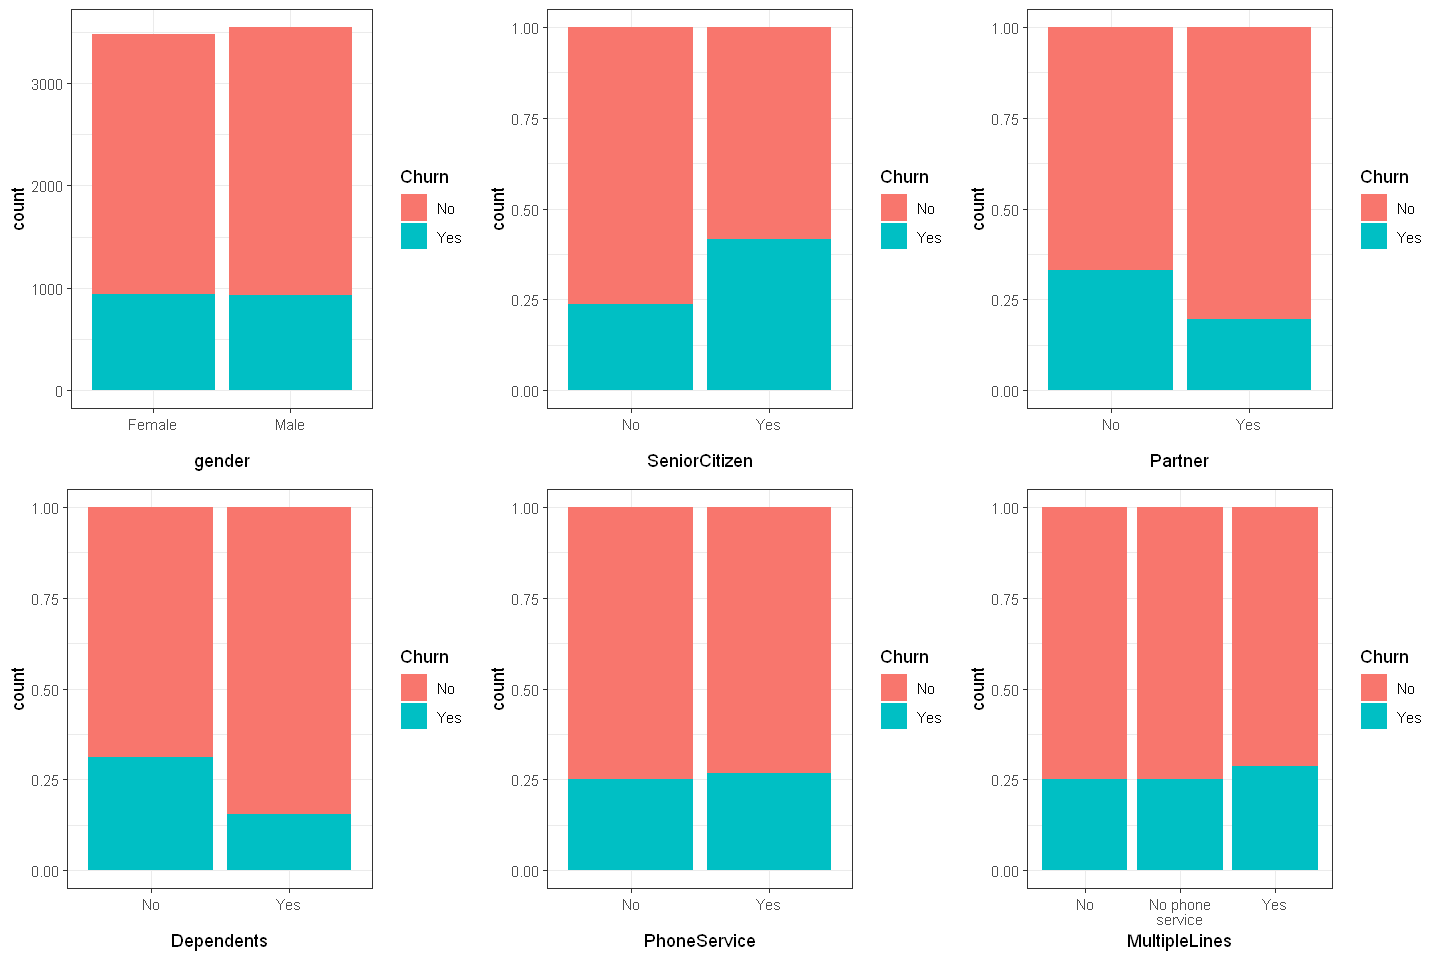

In [20]:
options(repr.plot.width = 12, repr.plot.height = 8)
plot_grid(ggplot(telco, aes(x=gender,fill=Churn))+ geom_bar()+ theme_bw(), 
          ggplot(telco, aes(x=SeniorCitizen,fill=Churn))+ geom_bar(position = 'fill')+theme_bw(),
          ggplot(telco, aes(x=Partner,fill=Churn))+ geom_bar(position = 'fill')+theme_bw(),
          ggplot(telco, aes(x=Dependents,fill=Churn))+ geom_bar(position = 'fill')+theme_bw(),
          ggplot(telco, aes(x=PhoneService,fill=Churn))+ geom_bar(position = 'fill')+theme_bw(),
          ggplot(telco, aes(x=MultipleLines,fill=Churn))+ geom_bar(position = 'fill')+theme_bw()+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          align = "h")

- Higher churn rate for `Fiber optic internet service`
- Customers without `online backup` and `tech support` left in the past month (that is what churn meant)

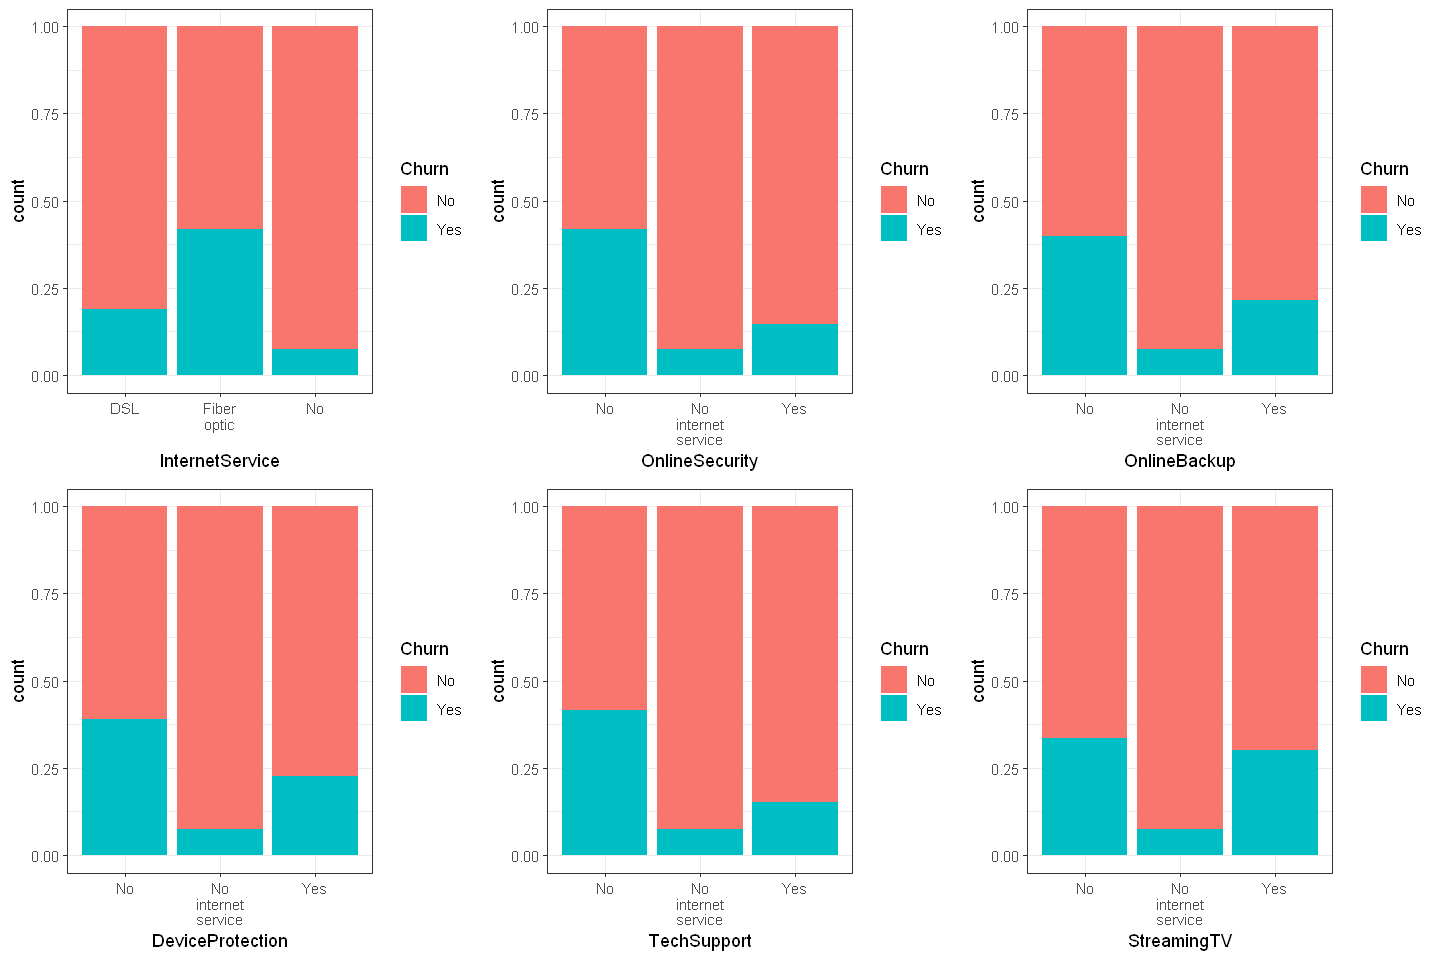

In [21]:
plot_grid(
    ggplot(telco, aes(x=InternetService,fill=Churn))+ geom_bar(position = 'fill')+theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x=OnlineSecurity,fill=Churn))+ geom_bar(position = 'fill')+theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x=OnlineBackup,fill=Churn))+ geom_bar(position = 'fill')+theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x=DeviceProtection,fill=Churn))+ geom_bar(position = 'fill')+theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x=TechSupport,fill=Churn))+ geom_bar(position = 'fill')+theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x=StreamingTV,fill=Churn))+ geom_bar(position = 'fill')+theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    align = "h"
)

- A large percent of customers with `month subscription` left compared to those with 2 years contract
- Higher churn rate for customers using paperless biling option
- Customers using electronic check payment method tend to leave the platform compare to others

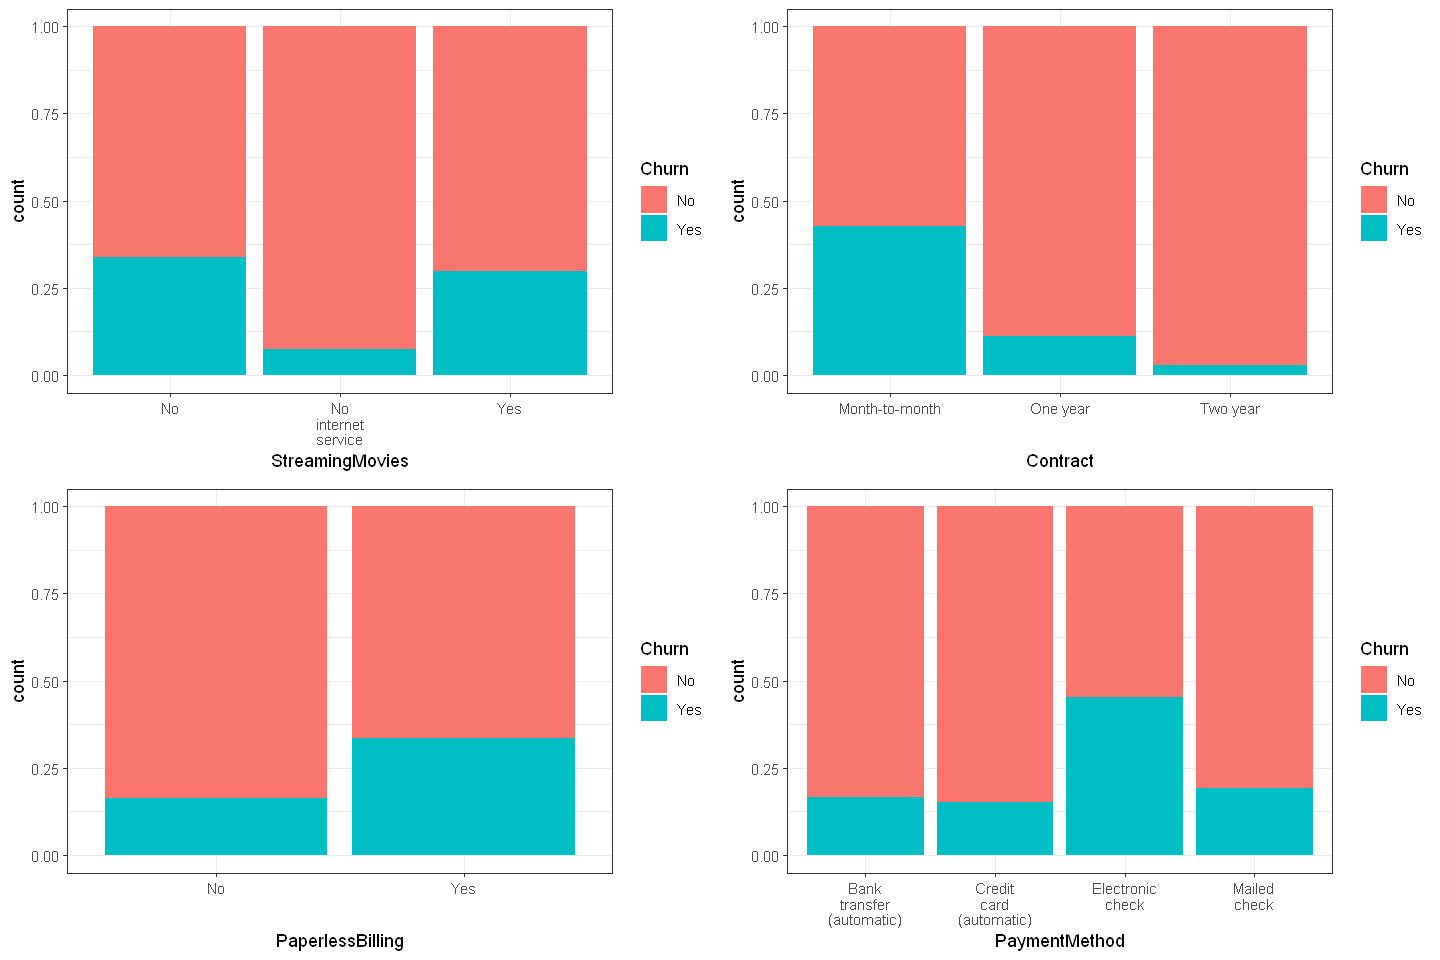

In [22]:
plot_grid(
    ggplot(telco, aes(x = StreamingMovies, fill = Churn)) + geom_bar(position = 'fill') + theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x = Contract, fill = Churn)) + geom_bar(position = 'fill') + theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x = PaperlessBilling, fill = Churn)) + geom_bar(position = 'fill') + theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    ggplot(telco, aes(x = PaymentMethod, fill = Churn)) + geom_bar(position = 'fill') + theme_bw() +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
    align = "h"
)

## Analyzing The Continuous Variables

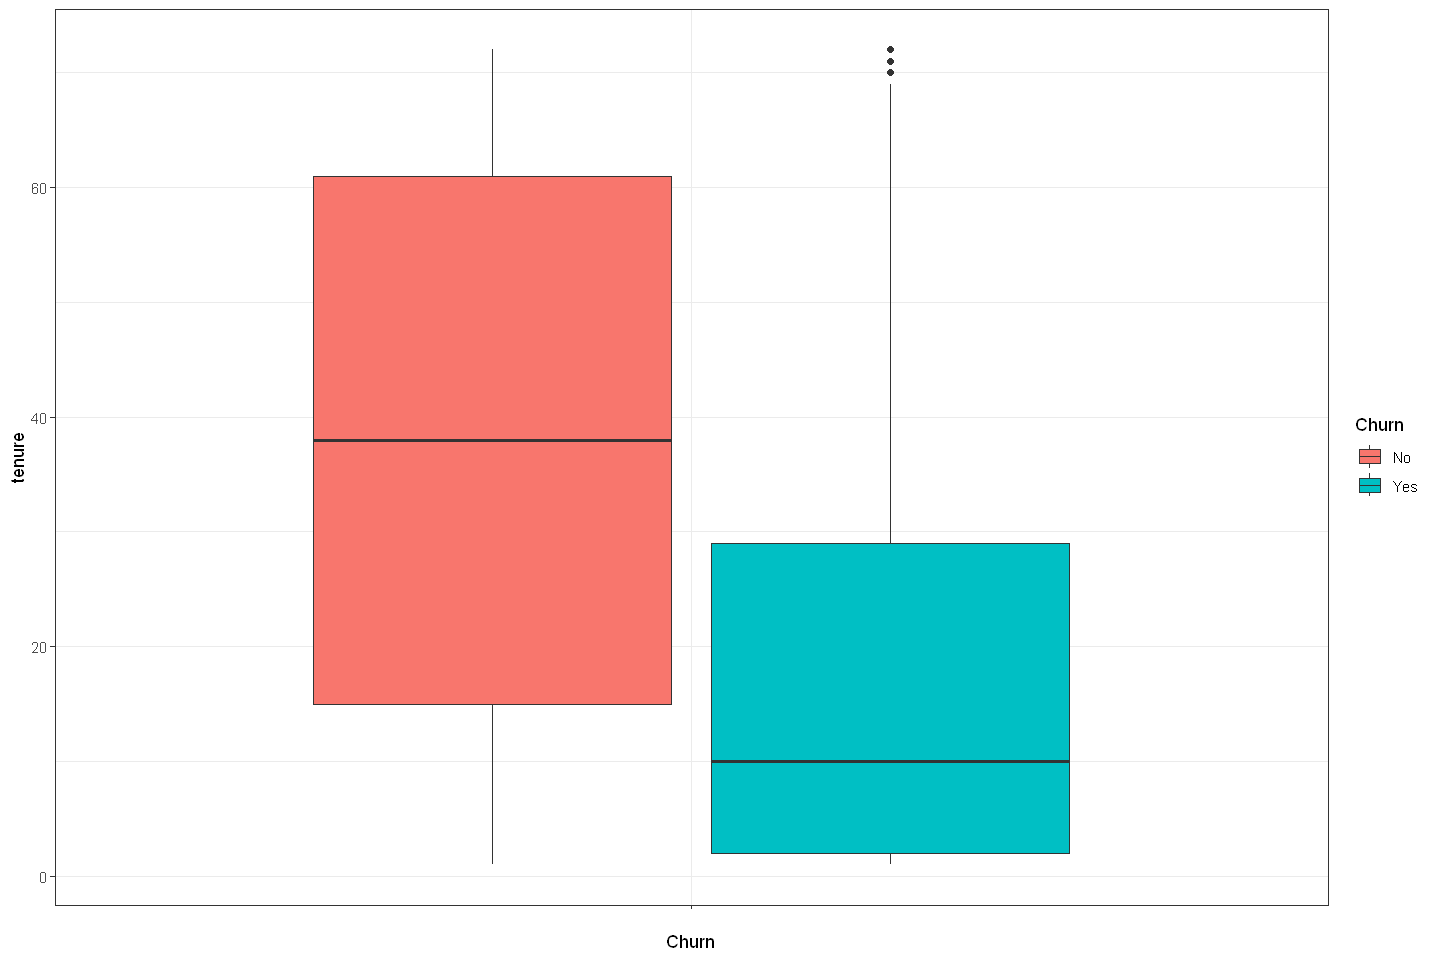

In [23]:
ggplot(telco, aes(y = tenure, x = "", fill = Churn)) +
    geom_boxplot() +
    theme_bw() +
    xlab("Churn")

The median tenure of customers who left is around 10 months

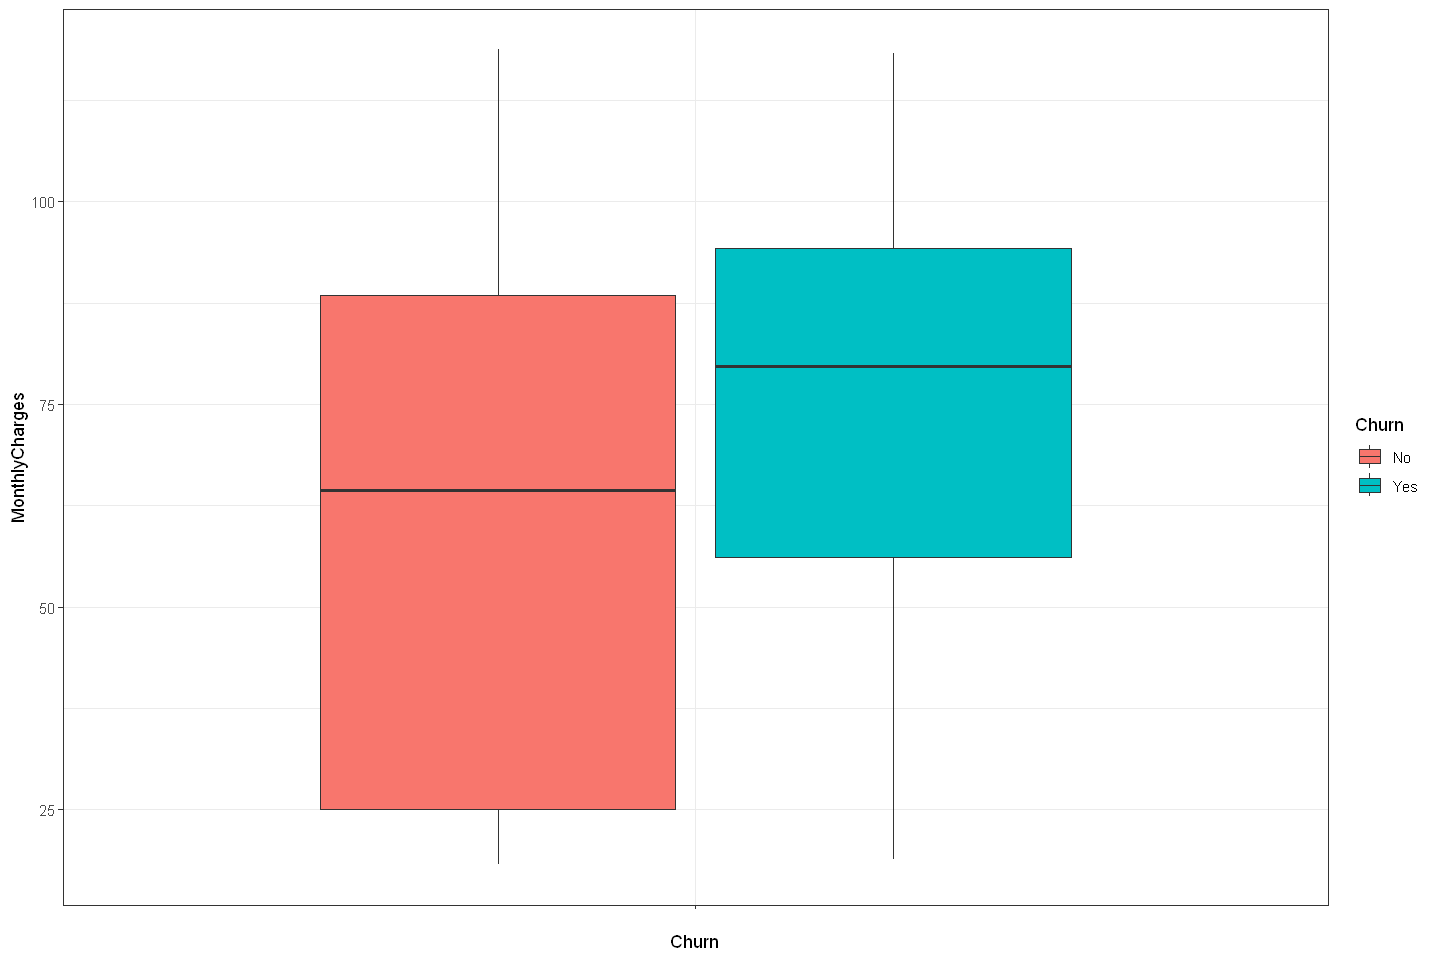

In [24]:
ggplot(telco, aes(y = MonthlyCharges, x= "", fill = Churn)) +
    geom_boxplot() +
    theme_bw() +
    xlab("Churn")

For churned customers, they have a higher monthly charges, the median is above 75

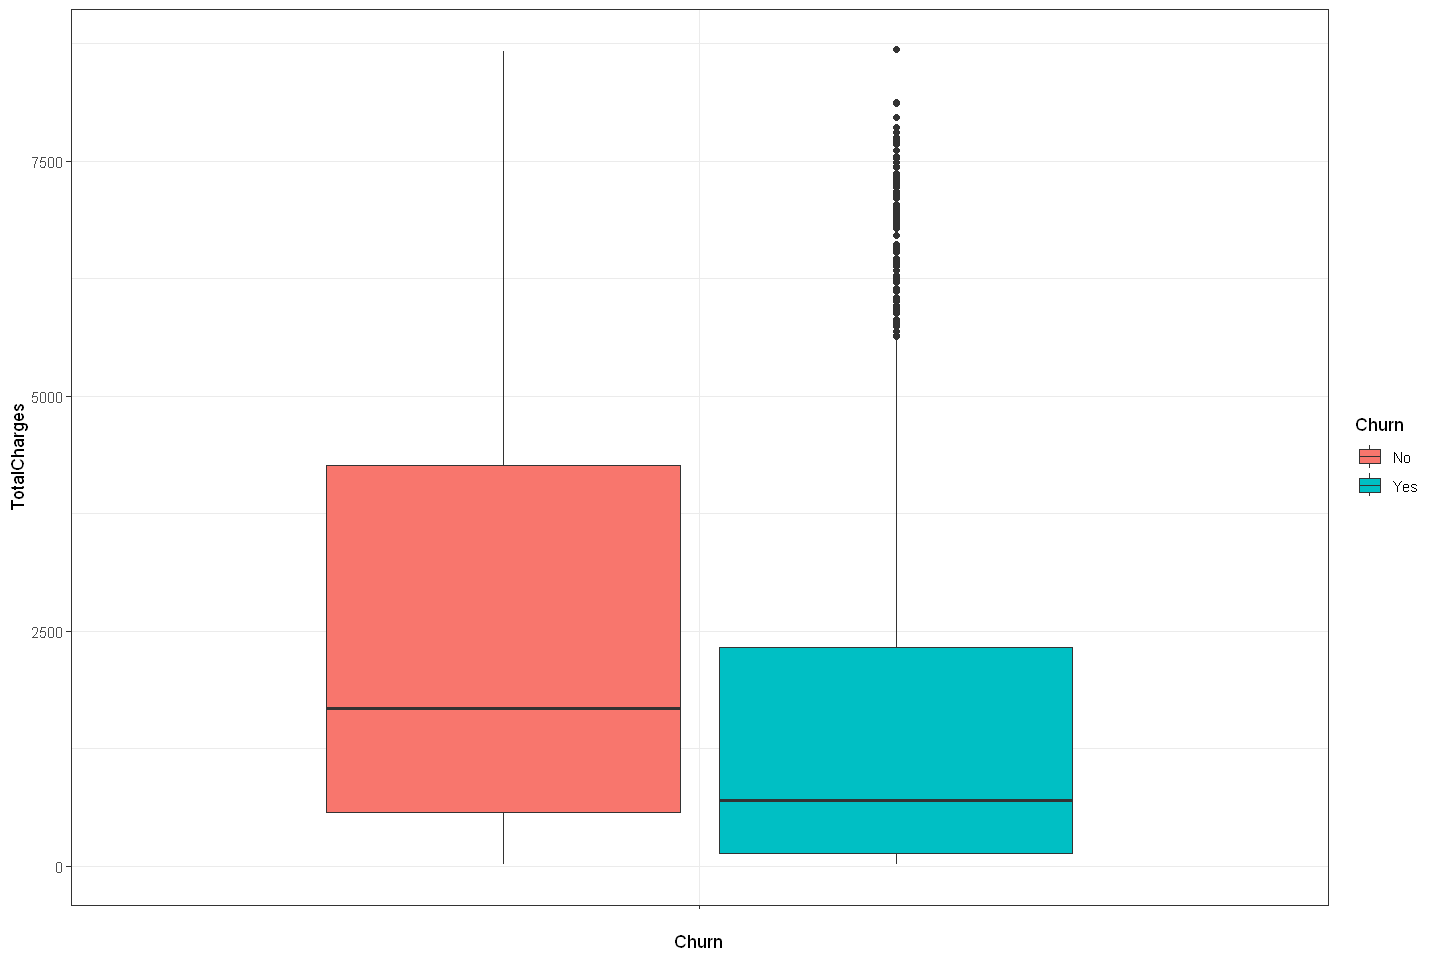

In [25]:
ggplot(telco, aes(y = TotalCharges, x = "", fill = Churn)) +
    geom_boxplot() +
    theme_bw() +
    xlab("Churn")

Median total charges of churned customers are low

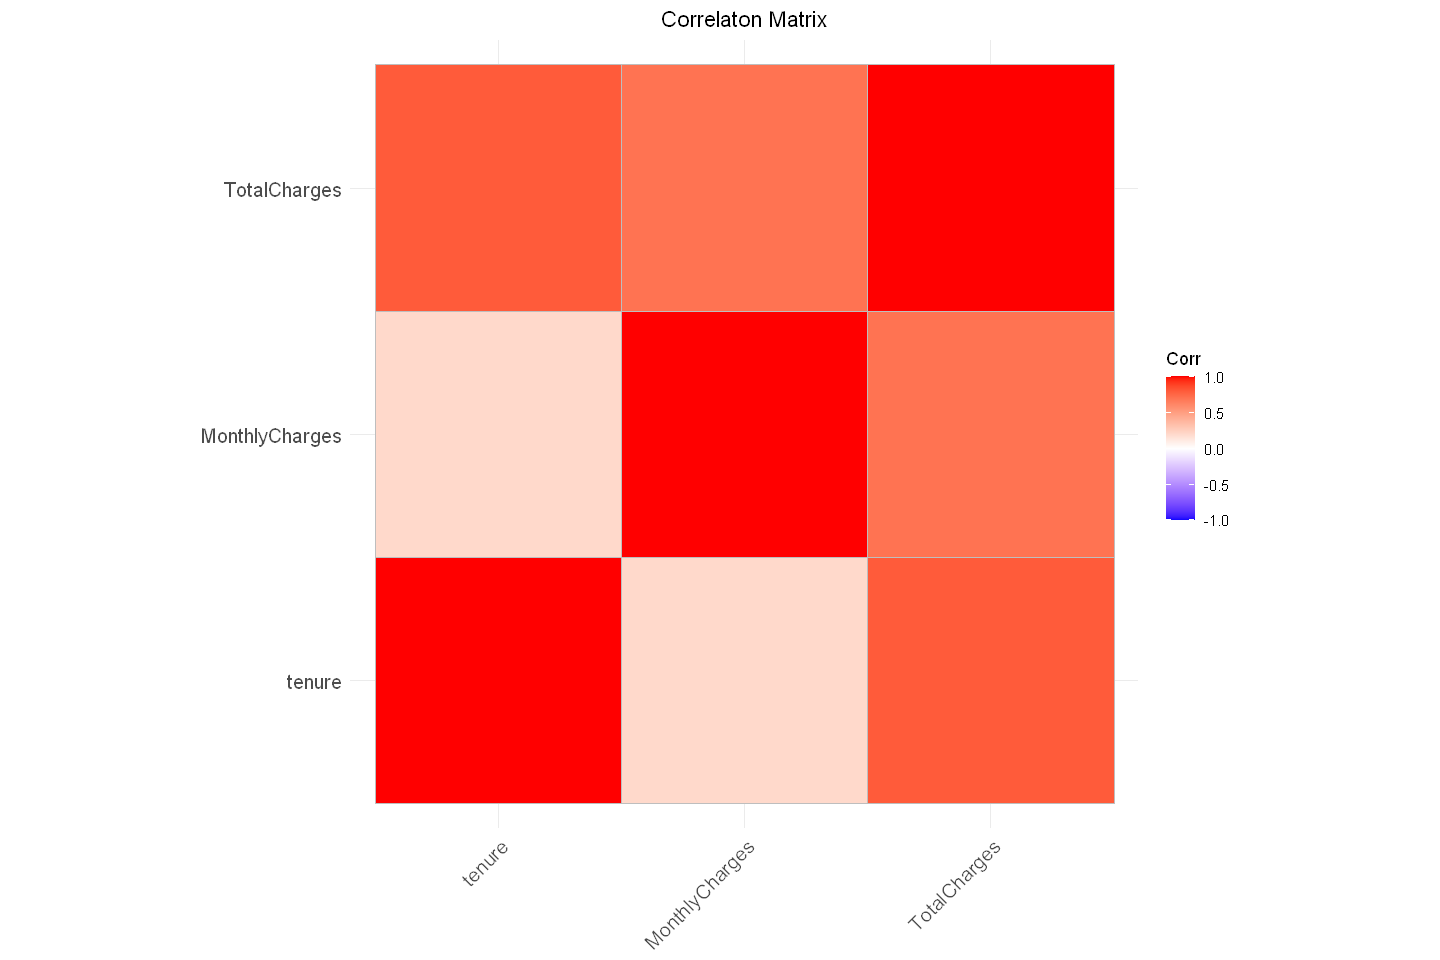

In [27]:
# correlation matrix
telco_cor <- round(cor(telco[,c("tenure", "MonthlyCharges", "TotalCharges")]), 1)

ggcorrplot(telco_cor, title = "Correlaton Matrix") +
    theme(plot.title = element_text(hjust = 0.5))

A positive correlation between total charges and monthly charges/ tenure

We also want to check for outliers for the continuous variables

numeric(0)

numeric(0)

numeric(0)

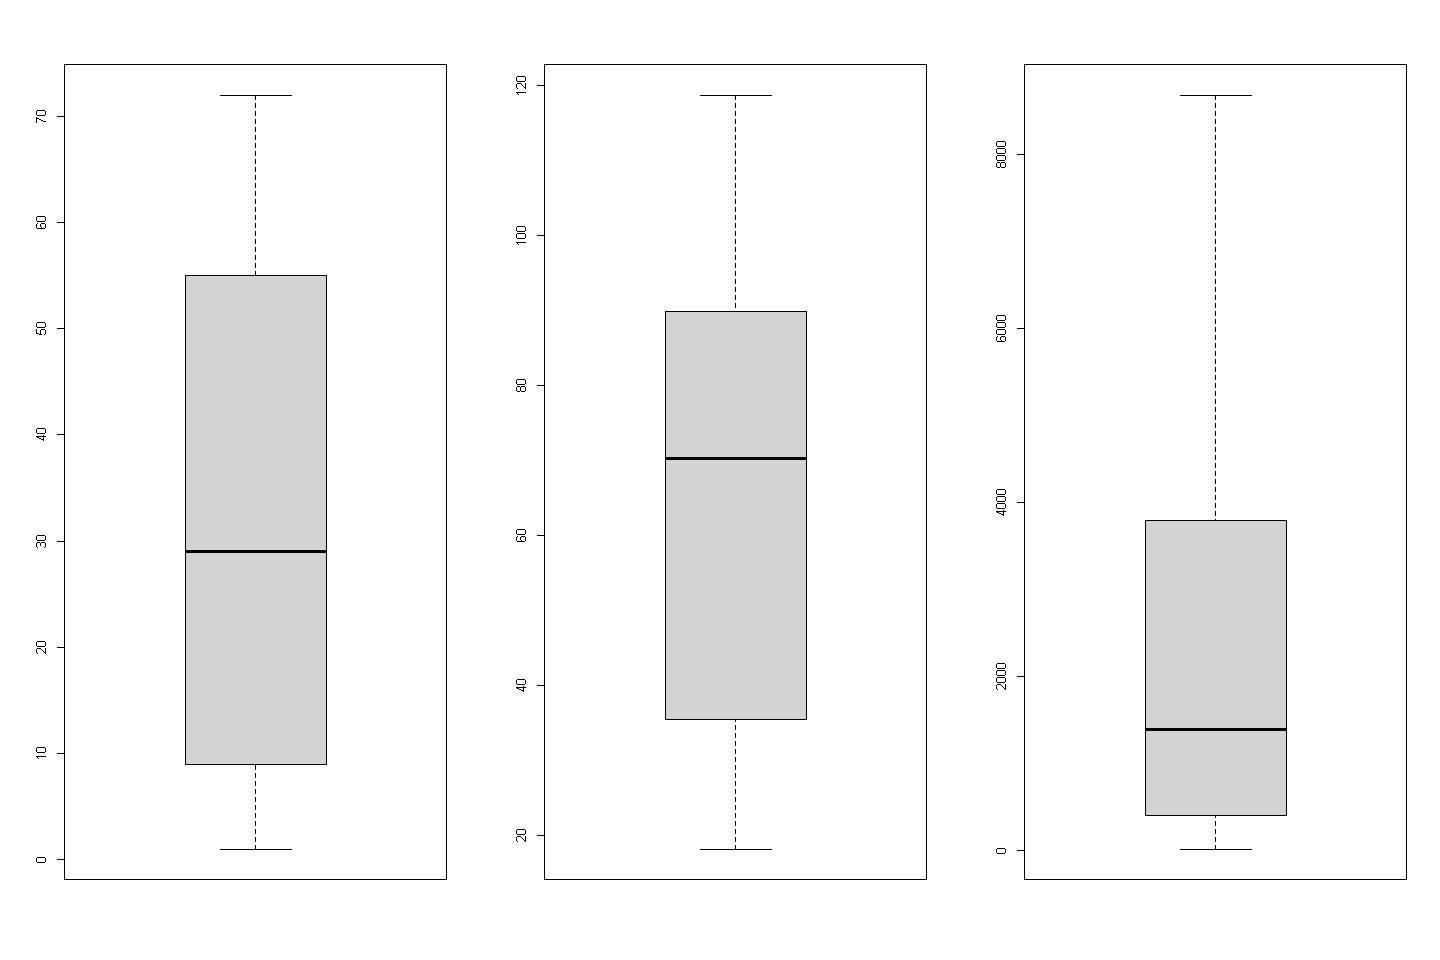

In [31]:
par(mfrow = c(1,3))

boxplot(telco$tenure)$out
boxplot(telco$MonthlyCharges)$out
boxplot(telco$TotalCharges)$out

## Preparing Data
- Clean categorical features
- Standardising continuous features
- Creating derived features
- Dummy variables for factor variables
- Train test splitting

In [32]:
# clean the categorical variables
telco <- data.frame(lapply(telco, function(x){
    gsub("No internet service", "No", x)
}))

telco <- data.frame(lapply(telco, function(x){
    gsub("No phone service", "No", x)
}))

In [33]:
# standardize the numerical variables
num_columns <- c("tenure", "MonthlyCharges", "TotalCharges")
telco[num_columns] <- sapply(telco[num_columns], as.numeric)
telco_int <- telco[, c("tenure", "MonthlyCharges", "TotalCharges")]
telco_int <- data.frame(scale(telco_int))

In [42]:
# derived features a.k.a feature engineering
telco <- mutate(telco, tenure_bin = tenure)

telco$tenure_bin[telco$tenure_bin >= 0 & telco$tenure_bin <= 12] <- "0-1 year"
telco$tenure_bin[telco$tenure_bin > 12 & telco$tenure_bin <= 24] <- "1-2 years"
telco$tenure_bin[telco$tenure_bin > 24 & telco$tenure_bin <= 36] <- "2-3 years"
telco$tenure_bin[telco$tenure_bin > 36 & telco$tenure_bin <= 48] <- "3-4 years"
telco$tenure_bin[telco$tenure_bin > 48 & telco$tenure_bin <= 60] <- "4-5 years"
telco$tenure_bin[telco$tenure_bin > 60 & telco$tenure_bin <= 72] <- "5-6 years"

telco$tenure_bin <- as.factor(telco$tenure_bin)

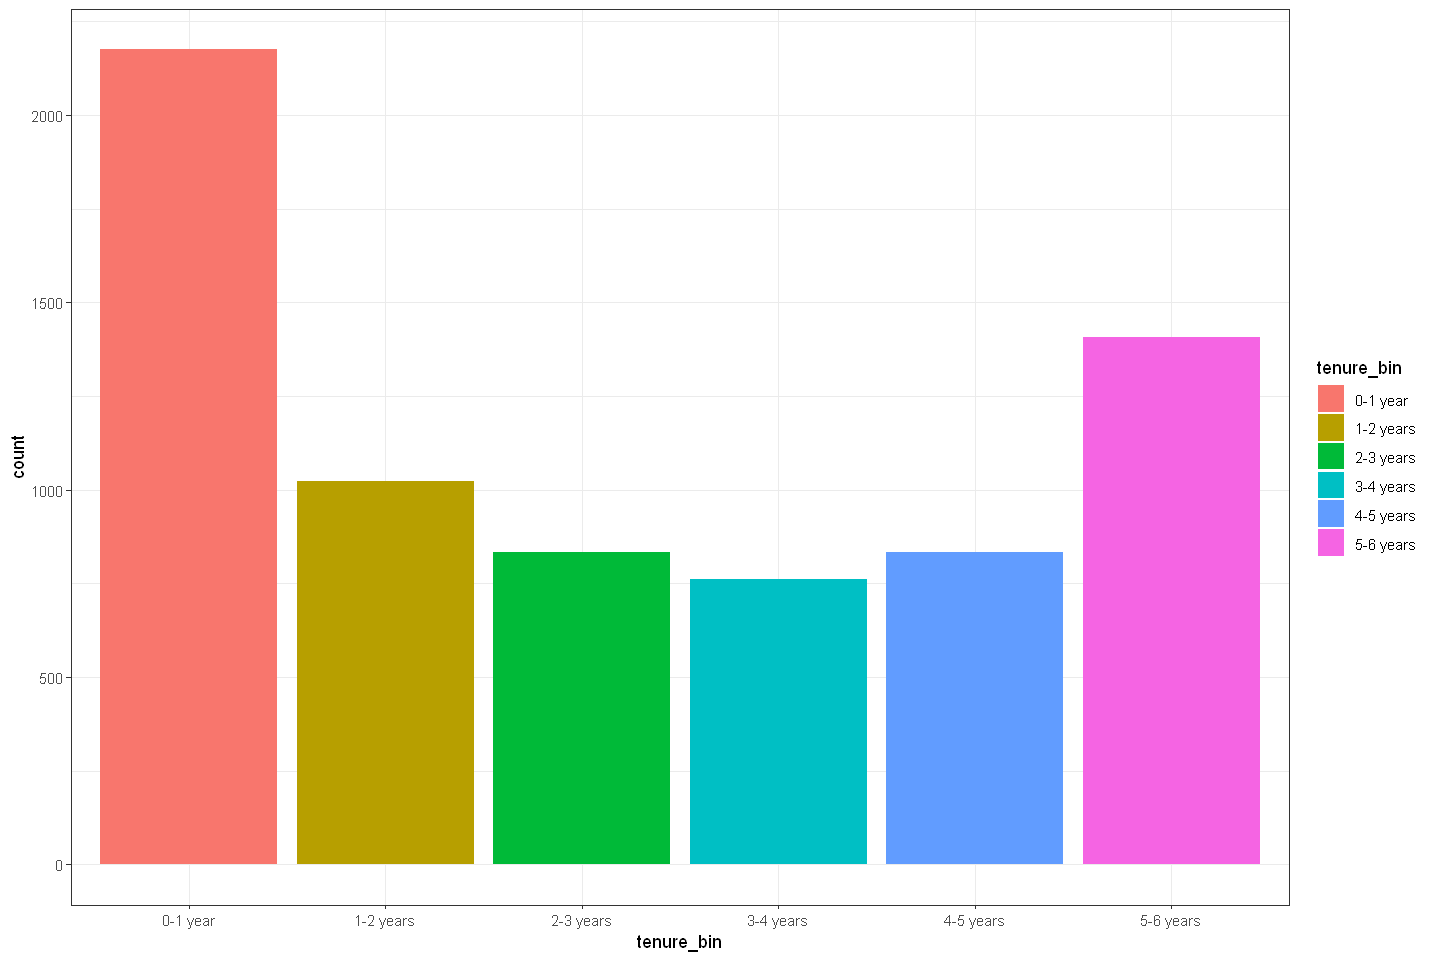

In [43]:
# check the distribution
ggplot(telco, aes(tenure_bin, fill = tenure_bin)) +
    geom_bar() +
    theme_bw()

- We can see that most customers are either 5-6 years or 1-2 years tenure

In [44]:
# dummy variables
telco_cat <- telco[,-c(1,6,19,20)]

dummy <- data.frame(sapply(telco_cat, function(x) data.frame(model.matrix(~x-1, data = telco_cat))[,-1]))

head(dummy)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService.xFiber.optic,InternetService.xNo,OnlineSecurity,OnlineBackup,⋯,PaperlessBilling,PaymentMethod.xCredit.card..automatic.,PaymentMethod.xElectronic.check,PaymentMethod.xMailed.check,Churn,tenure_bin.x1.2.years,tenure_bin.x2.3.years,tenure_bin.x3.4.years,tenure_bin.x4.5.years,tenure_bin.x5.6.years
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,1,0,0,0,0,0,0,1,⋯,1,0,1,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,⋯,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,1,1,⋯,1,0,0,1,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,1,0,0,0,⋯,1,0,1,0,1,0,0,0,0,0
6,0,0,0,0,1,1,1,0,0,0,⋯,1,0,1,0,1,0,0,0,0,0


In [45]:
# combine the data
telco_final <- cbind(telco_int, dummy)
head(telco_final, 2)

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService.xFiber.optic,⋯,PaperlessBilling,PaymentMethod.xCredit.card..automatic.,PaymentMethod.xElectronic.check,PaymentMethod.xMailed.check,Churn,tenure_bin.x1.2.years,tenure_bin.x2.3.years,tenure_bin.x3.4.years,tenure_bin.x4.5.years,tenure_bin.x5.6.years
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.28015700,-1.1616113,-0.9941234,0,0,1,0,0,0,0,⋯,1,0,1,0,0,0,0,0,0,0
2,0.06429811,-0.2608594,-0.1737275,1,0,0,0,1,0,0,⋯,0,0,0,1,0,0,1,0,0,0


In [47]:
# train test split
set.seed(123)
indices = sample.split(telco_final$Churn, SplitRatio = 0.7)
train = telco_final[indices,]
validation = telco_final[!(indices),]

In [48]:
# logistic regression
model_1 = glm(Churn ~ ., data = train, family = "binomial")
summary(model_1)


Call:
glm(formula = Churn ~ ., family = "binomial", data = train)

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                            -4.711690   1.580952  -2.980 0.002880
tenure                                 -2.419264   0.319733  -7.567 3.83e-14
MonthlyCharges                         -1.523039   1.152472  -1.322 0.186321
TotalCharges                            0.236922   0.200225   1.183 0.236699
gender                                 -0.004319   0.078799  -0.055 0.956292
SeniorCitizen                           0.342668   0.102039   3.358 0.000784
Partner                                 0.049639   0.095330   0.521 0.602570
Dependents                             -0.148501   0.110427  -1.345 0.178693
PhoneService                            0.597310   0.785026   0.761 0.446729
MultipleLines                           0.529622   0.214832   2.465 0.013691
InternetService.xFiber.optic            2.048017   0.960709   2.132 0.0

Use StepAIC for variable selection - remove variable iteratively to get a subset of variable that gives the best performing model. 

In [58]:
model_2 <- stepAIC(model_1, direction = "both")

Start:  AIC=4041.29
Churn ~ tenure + MonthlyCharges + TotalCharges + gender + SeniorCitizen + 
    Partner + Dependents + PhoneService + MultipleLines + InternetService.xFiber.optic + 
    InternetService.xNo + OnlineSecurity + OnlineBackup + DeviceProtection + 
    TechSupport + StreamingTV + StreamingMovies + Contract.xOne.year + 
    Contract.xTwo.year + PaperlessBilling + PaymentMethod.xCredit.card..automatic. + 
    PaymentMethod.xElectronic.check + PaymentMethod.xMailed.check + 
    tenure_bin.x1.2.years + tenure_bin.x2.3.years + tenure_bin.x3.4.years + 
    tenure_bin.x4.5.years + tenure_bin.x5.6.years



                                         Df Deviance    AIC
- gender                                  1   3983.3 4039.3
- TechSupport                             1   3983.3 4039.3
- PaymentMethod.xCredit.card..automatic.  1   3983.4 4039.4
- Partner                                 1   3983.6 4039.6
- PaymentMethod.xMailed.check             1   3983.6 4039.6
- OnlineBackup                            1   3983.7 4039.7
- PhoneService                            1   3983.9 4039.9
- tenure_bin.x1.2.years                   1   3983.9 4039.9
- OnlineSecurity                          1   3984.0 4040.0
- DeviceProtection                        1   3984.7 4040.7
- TotalCharges                            1   3984.7 4040.7
- MonthlyCharges                          1   3985.0 4041.0
- Dependents                              1   3985.1 4041.1
<none>                                        3983.3 4041.3
- StreamingMovies                         1   3986.5 4042.5
- StreamingTV                           

In [59]:
summary(model_2)


Call:
glm(formula = Churn ~ tenure + MonthlyCharges + SeniorCitizen + 
    MultipleLines + InternetService.xFiber.optic + InternetService.xNo + 
    OnlineSecurity + StreamingTV + StreamingMovies + Contract.xOne.year + 
    Contract.xTwo.year + PaperlessBilling + PaymentMethod.xElectronic.check + 
    tenure_bin.x2.3.years + tenure_bin.x3.4.years + tenure_bin.x4.5.years + 
    tenure_bin.x5.6.years + TechSupport, family = "binomial", 
    data = train)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -3.37123    0.27189 -12.399  < 2e-16 ***
tenure                          -2.07853    0.17751 -11.709  < 2e-16 ***
MonthlyCharges                  -0.52335    0.19800  -2.643 0.008213 ** 
SeniorCitizen                    0.37111    0.10031   3.700 0.000216 ***
MultipleLines                    0.38516    0.10755   3.581 0.000342 ***
InternetService.xFiber.optic     1.28144    0.22881   5.601 2.14e-08 ***
InternetService.

We can also use VIF to get rid of redundant predictors that have high multicollinearity between them. Multicollinearity exists when two or more predictor variables are highly related to each other, and then it becomes difficult to understand the impact of an independent variable on the dependent variable.

The Variance Inflation Factor(VIF) is used to measure the multicollinearity between predictor variables in a model. A predictor having a VIF of 2 or less is generally considered safe and it can be assumed that it is not correlated with other predictor variables. Higher the VIF, greater is the correlation of the predictor variable w.r.t other predictor variables. However, Predictors with high VIF may have high p-value(or highly significant), hence, we need to see the significance of the Predictor variable before removing it from our model.

In [60]:
print(vif(model_2))

                         tenure                  MonthlyCharges 
                      15.076710                       20.162188 
                  SeniorCitizen                   MultipleLines 
                       1.100707                        1.838876 
   InternetService.xFiber.optic             InternetService.xNo 
                       8.225529                        2.489968 
                 OnlineSecurity                     StreamingTV 
                       1.246308                        2.206225 
                StreamingMovies              Contract.xOne.year 
                       2.122071                        1.386381 
             Contract.xTwo.year                PaperlessBilling 
                       1.371229                        1.125064 
PaymentMethod.xElectronic.check           tenure_bin.x2.3.years 
                       1.149683                        2.656673 
          tenure_bin.x3.4.years           tenure_bin.x4.5.years 
                       4.

In [61]:
# remove device protection
model_3 <- update(model_2, . ~ . -StreamingTV)
summary(model_3)


Call:
glm(formula = Churn ~ tenure + MonthlyCharges + SeniorCitizen + 
    MultipleLines + InternetService.xFiber.optic + InternetService.xNo + 
    OnlineSecurity + StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xElectronic.check + tenure_bin.x2.3.years + 
    tenure_bin.x3.4.years + tenure_bin.x4.5.years + tenure_bin.x5.6.years + 
    TechSupport, family = "binomial", data = train)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -2.95481    0.24736 -11.945  < 2e-16 ***
tenure                          -2.04047    0.17657 -11.556  < 2e-16 ***
MonthlyCharges                  -0.07297    0.16228  -0.450 0.652962    
SeniorCitizen                    0.37557    0.10002   3.755 0.000173 ***
MultipleLines                    0.28240    0.10363   2.725 0.006427 ** 
InternetService.xFiber.optic     0.84130    0.19835   4.242 2.22e-05 ***
InternetService.xNo             -1.

In [62]:
print(vif(model_3))

                         tenure                  MonthlyCharges 
                      14.948660                       13.493615 
                  SeniorCitizen                   MultipleLines 
                       1.100248                        1.716090 
   InternetService.xFiber.optic             InternetService.xNo 
                       6.207416                        2.242930 
                 OnlineSecurity                 StreamingMovies 
                       1.192771                        2.105943 
             Contract.xOne.year              Contract.xTwo.year 
                       1.386351                        1.367679 
               PaperlessBilling PaymentMethod.xElectronic.check 
                       1.118802                        1.136880 
          tenure_bin.x2.3.years           tenure_bin.x3.4.years 
                       2.649466                        4.113115 
          tenure_bin.x4.5.years           tenure_bin.x5.6.years 
                       6.

In [63]:
final_model <- model_3

In [64]:
pred <- predict(final_model, type = "response", newdata = validation[,-24])
summary(pred)
validation$prob <- pred

# confusion matrix
pred_churn <- factor(ifelse(pred > 0.5, "Yes", "No"))
actual_churn <- factor(ifelse(validation$Churn == 1, "Yes", "No"))
table(pred_churn, actual_churn)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003172 0.039730 0.195851 0.267662 0.459730 0.899692 

          actual_churn
pred_churn   No  Yes
       No  1389  267
       Yes  160  294

In [65]:
# accuracy, sensitivity, specificity
cutoff_churn <- factor(ifelse(pred >= 0.5, "Yes", "No"))
conf_final <- confusionMatrix(cutoff_churn, actual_churn, positive = "Yes")

accuracy <- conf_final$overall[1]
sensitivity <- conf_final$byClass[1]
specificity <- conf_final$byClass[2]

accuracy
sensitivity
specificity

Accuracy 
0.7976303

Sensitivity 
  0.5240642

Specificity 
  0.8967076

We have a good accuracy and specificity with 50 percent cutoff. But the sensitivity is low, we want to find the optimal probability cutoff to yield the maximum accuracy, sensitivity and specificity. 

In [68]:
perform_fn <- function(cutoff){
    predicted_churn <- factor(ifelse(pred >= cutoff, "Yes", "No"))
    conf <- confusionMatrix(predicted_churn, actual_churn, positive = "Yes")
    accuracy <- conf$overall[1]
    sensitivity <- conf$byClass[1]
    specificity <- conf$byClass[2]
    out <- t(as.matrix(c(accuracy, sensitivity, specificity)))
    colnames(out) <- c("Accuracy", "Sensitivity", "Specificity")

    return(out)
}

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003172 0.039730 0.195851 0.267662 0.459730 0.899692 

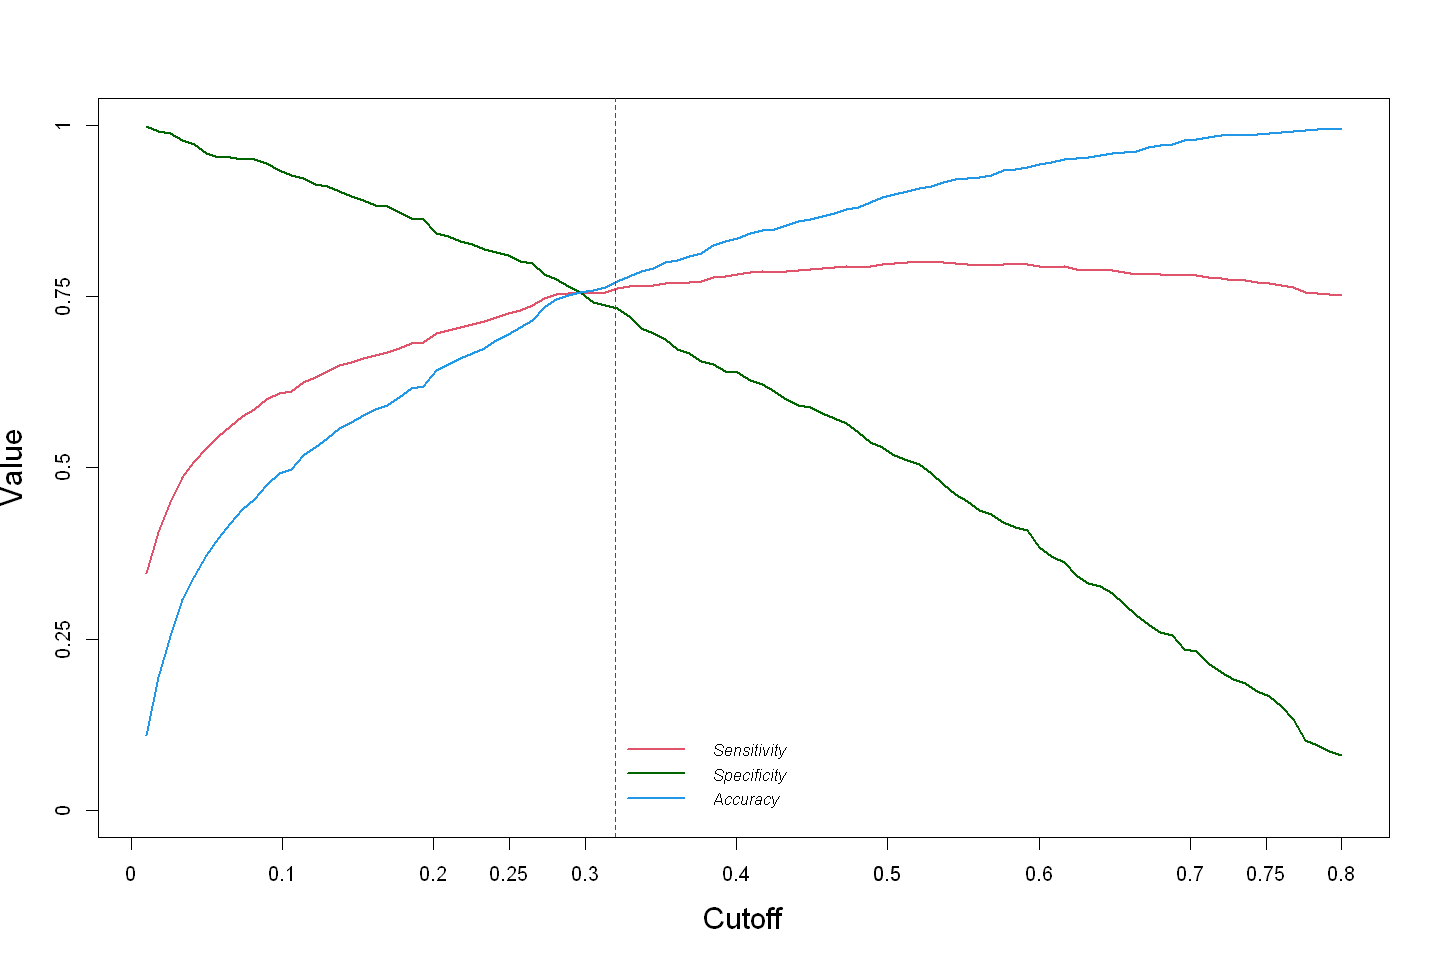

In [69]:
summary(pred)
s = seq(0.01, 0.80, length = 100)
OUT = matrix(0, 100, 3)

for (i in 1:100){
    OUT[i,] <- perform_fn(s[i])
}

plot(s, OUT[,1],xlab="Cutoff",ylab="Value",cex.lab=1.5,cex.axis=1.5,ylim=c(0,1),
     type="l",lwd=2,axes=FALSE,col=2)
axis(1,seq(0,1,length=5),seq(0,1,length=5),cex.lab=1.5)
axis(2,seq(0,1,length=5),seq(0,1,length=5),cex.lab=1.5)
lines(s,OUT[,2],col="darkgreen",lwd=2)
lines(s,OUT[,3],col=4,lwd=2)
box()
legend("bottom",col=c(2,"darkgreen",4,"darkred"),text.font =3,inset = 0.02,
       box.lty=0,cex = 0.8, 
       lwd=c(2,2,2,2),c("Sensitivity","Specificity","Accuracy"))
abline(v = 0.32, col="red", lwd=1, lty=2)
axis(1, at = seq(0.1, 1, by = 0.1))

In [70]:
# we will select 0.32 as the optimal value
# compute confusion matrix again

cutoff_churn <- factor(ifelse(pred >= 0.32, "Yes", "No"))
conf_final <- confusionMatrix(cutoff_churn, actual_churn, positive = "Yes")
accuracy <- conf_final$overall[1]
sensitivity <- conf_final$byClass[1]
specificity <- conf_final$byClass[2]

accuracy
sensitivity
specificity

Accuracy 
0.7611374

Sensitivity 
  0.7326203

Specificity 
  0.7714655

- Now we have a better value of accuracy, sensitivity and specificity in the validation data

## Decision Tree
Splits the data into multiple sets and each set is further split into subsets to arrive at a tree like structure and make a decision. Homogeneity is the basic concept that helps to determine the attribute on which a split should be made. A split that results into the most homogenous subset is often considered better and step by step each attribute is chosen that maximizes the homogeneity of each subset. Further, this homogeneity is measured using different ways such as Gini Index, Entropy and Information Gain.

In [71]:
set.seed(123)
telco_final$Churn <- as.factor(telco_final$Churn)

indices = sample.split(telco_final$Churn, SplitRatio = 0.7)
train = telco_final[indices,]
validation = telco_final[!(indices),]

In [80]:
remove.packages("rpart")
suppressMessages({
library(rpart)
library(rpart.plot)
})

Removing package from 'C:/Users/Khor Kean Teng/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



In [81]:
Dtree = rpart(Churn ~ ., data = train, method = "class")
summary(Dtree)

Call:
rpart(formula = Churn ~ ., data = train, method = "class")
  n= 4922 

         CP nsplit rel error    xerror       xstd
1 0.1100917      0 1.0000000 1.0000000 0.02369296
2 0.0100000      2 0.7798165 0.8012232 0.02195745

Variable importance
                         tenure                    TotalCharges 
                             28                              24 
   InternetService.xFiber.optic                  MonthlyCharges 
                             17                              16 
PaymentMethod.xElectronic.check                   MultipleLines 
                              5                               5 
                    StreamingTV     PaymentMethod.xMailed.check 
                              4                               1 
                        Partner 
                              1 

Node number 1: 4922 observations,    complexity param=0.1100917
  predicted class=0  expected loss=0.2657456  P(node) =1
    class counts:  3614  1308
   probabiliti

In [82]:
# predicting
DTPred <- predict(Dtree, type = "class", newdata = validation[,-24])

In [83]:
# see the confusion matrix
confusionMatrix(validation$Churn, DTPred)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1435  114
         1  343  218
                                          
               Accuracy : 0.7834          
                 95% CI : (0.7652, 0.8008)
    No Information Rate : 0.8427          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3621          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8071          
            Specificity : 0.6566          
         Pos Pred Value : 0.9264          
         Neg Pred Value : 0.3886          
             Prevalence : 0.8427          
         Detection Rate : 0.6801          
   Detection Prevalence : 0.7341          
      Balanced Accuracy : 0.7319          
                                          
       'Positive' Class : 0               
                        

- This model gives slightly better accuracy than the logistic regression model. The sensitivity is also higher, but the specificity is lower. 

## Random Forest
Often known as an ensemble of a large number of Decision Trees, that uses bootstrapped aggregation technique to choose random samples from a dataset to train each tree in the forest. The final prediction in a RandomForest is an aggregation of prediction of individual trees. One of the advantages of RandomForest is that, it gives out-of-bag(OOB) error estimates, which is the mean prediction error on a training sample, using the trees that do not have that training sample in their bootstrap sample. It may act as a cross validation error and eliminate the need of using test/validation data, thereby increasing the training the data. However, I am still going to use train and validation concept here as well, like I did in the above two Models.

In [85]:
suppressMessages(library(randomForest))
set.seed(123)

telco_final$Churn <- as.factor(telco_final$Churn)

indices = sample.split(telco_final$Churn, SplitRatio = 0.7)
train = telco_final[indices,]
validation = telco_final[!(indices),]

OOB error estimate comes to around 20 percent, the model has around 79 percent out of sample accuracy for training set.

In [86]:
model.rf <- randomForest(Churn ~ ., data = train, ntree = 500, mtry = 4, proximity = FALSE, important = FALSE, do.trace = FALSE)
model.rf


Call:
 randomForest(formula = Churn ~ ., data = train, ntree = 500,      mtry = 4, proximity = FALSE, important = FALSE, do.trace = FALSE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 19.59%
Confusion matrix:
     0   1 class.error
0 3258 356  0.09850581
1  608 700  0.46483180

In [87]:
testPred <- predict(model.rf, newdata = validation[,-24])
table(testPred, validation$Churn)
confusionMatrix(validation$Churn, testPred)

        
testPred    0    1
       0 1392  283
       1  157  278

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1392  157
         1  283  278
                                          
               Accuracy : 0.7915          
                 95% CI : (0.7735, 0.8086)
    No Information Rate : 0.7938          
    P-Value [Acc > NIR] : 0.6182          
                                          
                  Kappa : 0.4246          
                                          
 Mcnemar's Test P-Value : 2.536e-09       
                                          
            Sensitivity : 0.8310          
            Specificity : 0.6391          
         Pos Pred Value : 0.8986          
         Neg Pred Value : 0.4955          
             Prevalence : 0.7938          
         Detection Rate : 0.6597          
   Detection Prevalence : 0.7341          
      Balanced Accuracy : 0.7351          
                                          
       'Positive' Class : 0               
                        

- The model accuracy is about 79 percent, the sensitivity is high at 83 percent, but the specificity is low at 64 percent.

### Variable Importance Plot
Below is the variable importance plot, that shows the most significant attribute in decreasing order by mean decrease in Gini. The Mean decrease Gini measures how pure the nodes are at the end of the tree. Higher the Gini Index, better is the homogeneity.

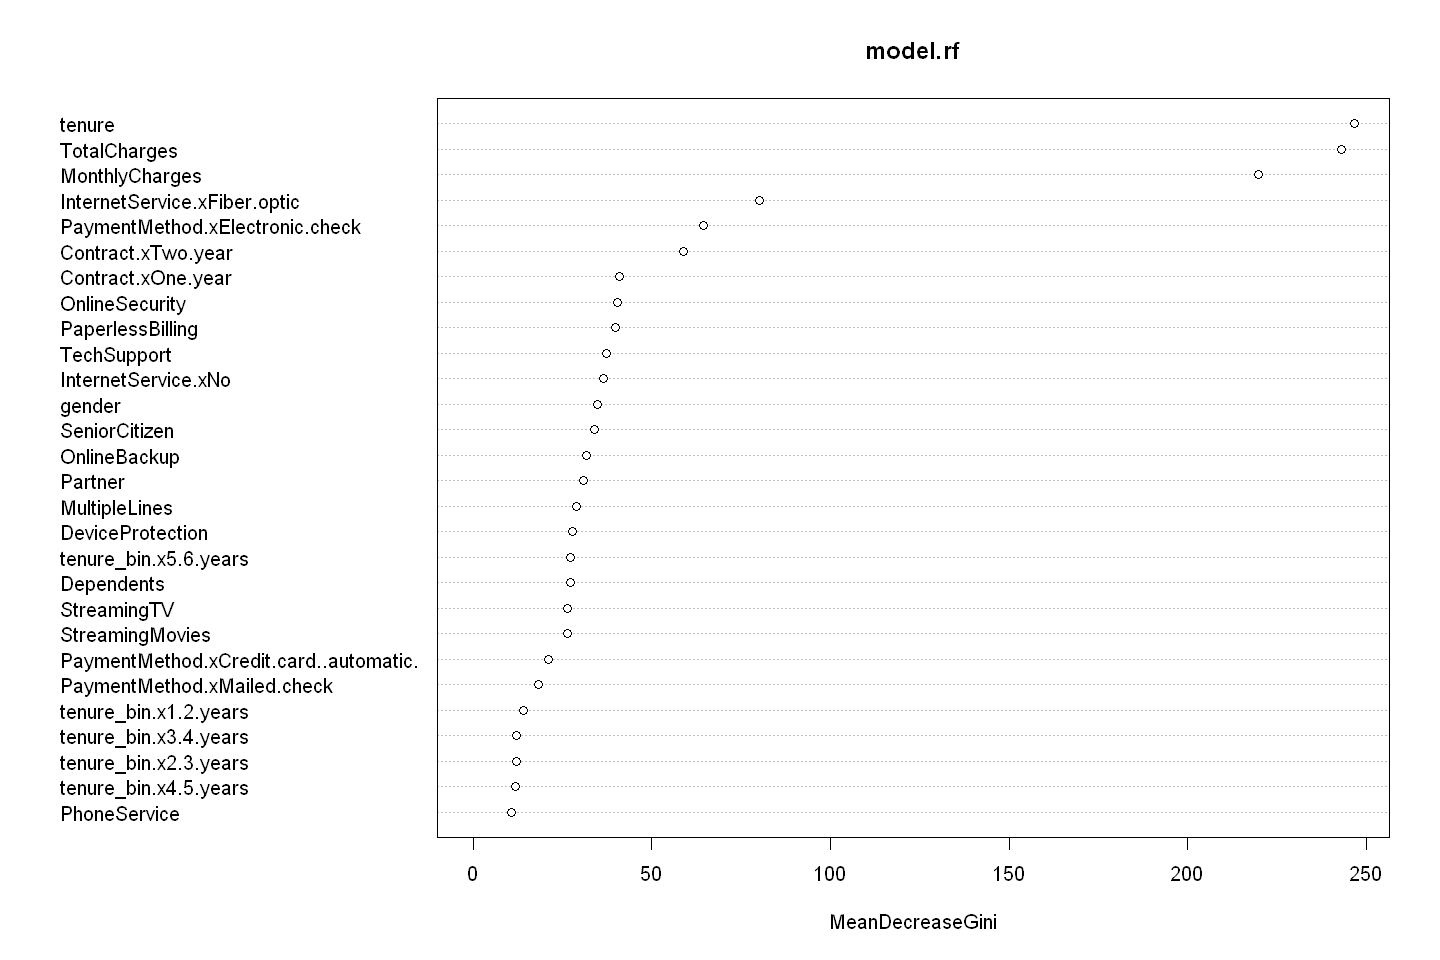

In [88]:
varImpPlot(model.rf)

### AUC Checking

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



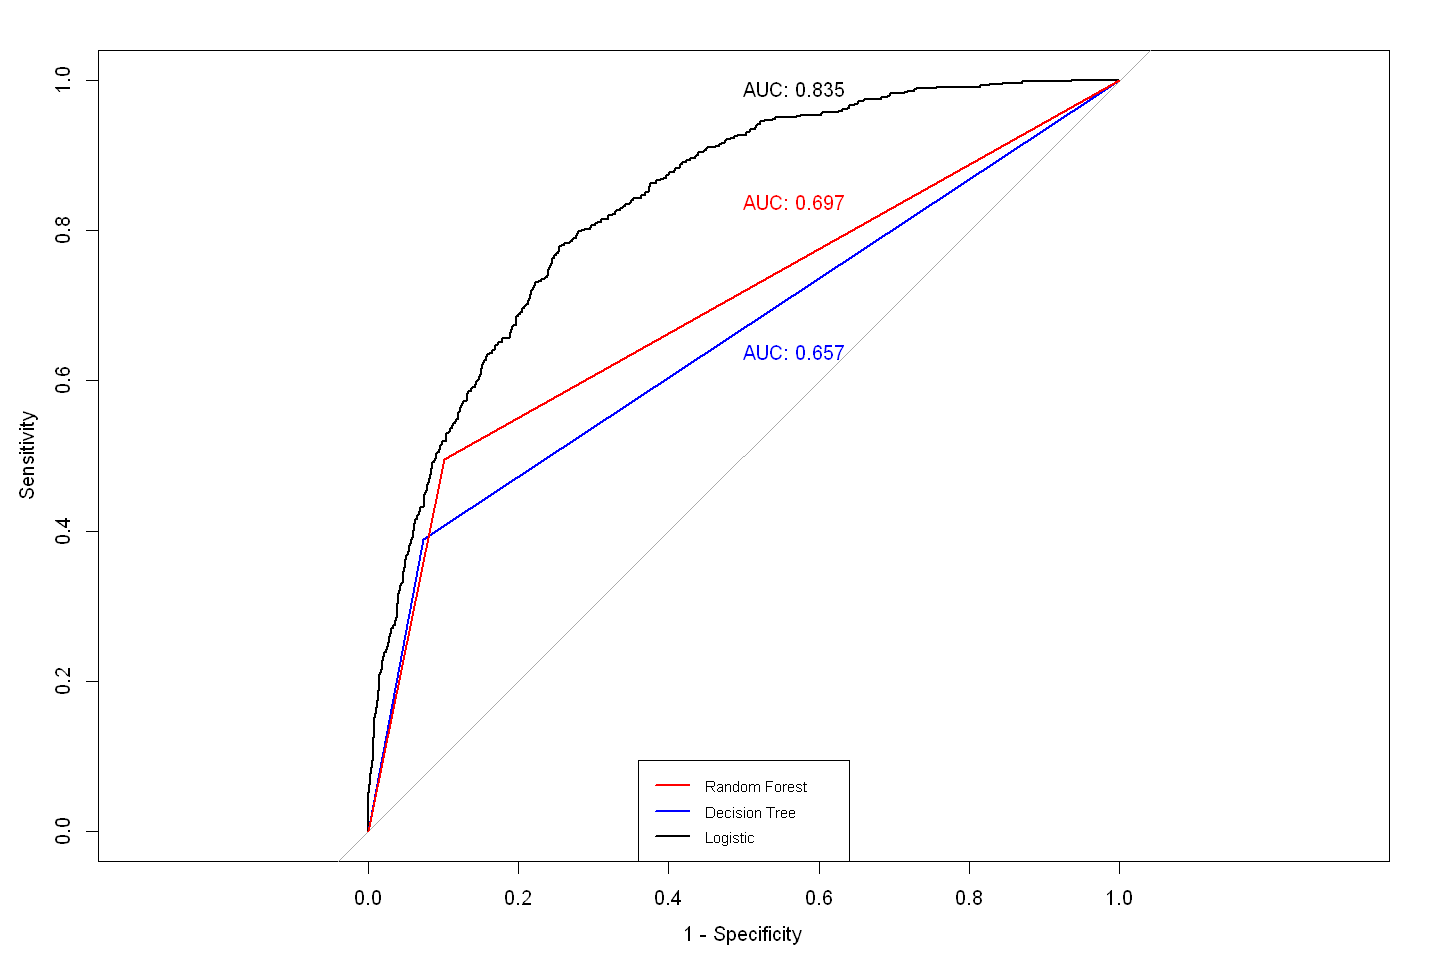

In [92]:
glm.roc <- roc(response = validation$Churn, predictor = as.numeric(pred))
DT.roc <- roc(response = validation$Churn, predictor = as.numeric(DTPred))
RF.roc <- roc(response = validation$Churn, predictor = as.numeric(testPred))

plot(glm.roc,      legacy.axes = TRUE, print.auc.y = 1.0, print.auc = TRUE)
plot(DT.roc, col = "blue", add = TRUE, print.auc.y = 0.65, print.auc = TRUE)
plot(RF.roc, col = "red" , add = TRUE, print.auc.y = 0.85, print.auc = TRUE)
legend("bottom", c("Random Forest", "Decision Tree", "Logistic"),
       lty = c(1,1), lwd = c(2, 2), col = c("red", "blue", "black"), cex = 0.75)

Useful resources: http://rstudio-pubs-static.s3.amazonaws.com/277278_427ca6a7ce7c4eb688506efc7a6c2435.html